# Project: Advanced Lane Finding by Erick Ramirez

In [1]:

class Lines():
    '''Class to save the latest data to compare'''
    def __init__(self ,recent_count=10 ):
        
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last 5 fits of the right line
        self.recent_left_fitx = [] 
        # x values of the last 5 fits of the right line
        self.recent_right_fitx = [] 
        # x values of the last 5 fits of the right line
        self.current_left_fitx = None
        # x values of the last 5 fits of the right line
        self.current_right_fitx = None 
        #average x values of the fitted line over the last n iterations
        self.best_left_fitx = None     
        #average x values of the fitted line over the last n iterations
        self.best_right_fitx = None 
        self.left_fit = None
        self.right_fit= None
        self.recent_count = recent_count
        self.left_count = 0
        self.right_count = 0
        
        
    def set_ploty (self ,yimage_size):
        self.ploty = np.linspace(0, yimage_size-1, yimage_size)
        
    def get_best_fit(self):
        lindex = len(self.recent_left_fitx)
        rindex = len(self.recent_right_fitx)
        self.best_left_fitx=copy.copy(self.current_left_fitx)
        self.best_right_fitx=copy.copy(self.current_right_fitx)      
        self.detected = True
        if lindex>0:       
            if self.left_count<15:
                leftx=np.array([])
                lefty=np.array([])
                for recent_fitx in self.recent_left_fitx:
                    leftx = np.concatenate((leftx, recent_fitx), axis=0)
                    lefty = np.concatenate((lefty, self.ploty), axis=0)
                left_fit = np.polyfit(lefty, leftx, 2)
                average_left_fitx = left_fit[0]*self.ploty**2 + left_fit[1]*self.ploty + left_fit[2]
                lmean_squared_error = np.sqrt(((self.current_left_fitx - average_left_fitx) ** 2).mean())          
                if lmean_squared_error>40:
                    self.best_left_fitx = average_left_fitx
                    self.detected = False 
        self.left_fit =np.polyfit(self.ploty, self.best_left_fitx, 2)   
        self.recent_left_fitx.append(self.best_left_fitx)
        if lindex>self.recent_count:
            self.recent_left_fitx.pop(0)
        #####################################################################
        if rindex>0:
            if  self.right_count<15:
                righty=np.array([])
                rightx=np.array([])
                for recent_fitx in self.recent_right_fitx:
                    rightx = np.concatenate((rightx, recent_fitx), axis=0)
                    righty = np.concatenate((righty, self.ploty), axis=0)
                right_fit = np.polyfit(righty, rightx, 2)
                average_right_fitx = right_fit[0]*self.ploty**2 + right_fit[1]*self.ploty + right_fit[2]
                rmean_squared_error = np.sqrt(((self.current_right_fitx - average_right_fitx) ** 2).mean())
                if rmean_squared_error>40 :
                    self.detected = False 
                    self.best_right_fitx = average_right_fitx
        self.right_fit =np.polyfit(self.ploty, self.best_right_fitx, 2)
        self.recent_right_fitx.append(self.best_right_fitx)
        if rindex>self.recent_count:
            self.recent_right_fitx.pop(0)
            

#### 3.Use color mask and sobel filters to create a thresholded binary image: 
##### i.	Select yellow color: transform the RGB image to HSV image and use the following range: [22, 35, 80] to [100, 255, 255]
##### ii.	Select white color: transform the RGB image to HLS image and use the following range: [0, 180, 160] to [150, 255, 255]
##### iii.	Filter for saturation:  transform the RGB image to HLS image and use the following range: [20, 0, 100] to [100, 255, 255]
##### iv.	Apply color mask using Or operator: mask[(hsv_yellow ==255)| (hls == 255) | (hls_white == 255)] = 1
##### b.	Apply Sobel filter: This is applied in order to detect edges and remove the pavement color with a color mask using HSV image format.
##### c.	Combine color mask and Sobel Filter: Apply “or” operator for both outputs. 

In [2]:
import os
import numpy as np
import cv2
import pickle
import copy
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline


def hsv_select(img,lower_range,upper_range):
    """It's very useful to separate color components: Hue, Saturation, Value 
    in this case for lighting changes for yellow lines and Pavement color
    in the challenge video such as robustness to lighting changes"""
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Threshold the HSV image to get only the exected colors
    mask = cv2.inRange(hsv, lower_range, upper_range)
    return  mask

def hls_select(img, lower_range,upper_range):
    """It's very useful to separate color components: Hue, Lightness and Saturation
    in this case for lighting changes for white color
    in the challenge video such as robustness to lighting changes"""
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the image
    mask = cv2.inRange(hls, lower_range, upper_range)
    return  mask

def Color_mask (img): 
    """Select area of iterest of the image"""
    lower_hsv_yellow = np.array([22, 35, 80])#hsv for yellow lines
    upper_hsv_yellow = np.array([100, 255, 255])#hsv for yellow lines
    
    lower_hls_white = np.array([0, 180, 160])#hsv for white lines
    upper_hls_white = np.array([150, 255, 255])#hsv  for white lines
    
    
    lower_hls = np.array([20, 0, 100])#hls, filter for saturation
    upper_hls = np.array([100, 255, 255])#hsv, filter for saturation
    hsv_yellow = hsv_select (img,lower_hsv_yellow, upper_hsv_yellow)
    hls_white = hls_select (img,lower_hls_white, upper_hls_white)
    
    hls = hls_select (img,lower_hls, upper_hls)
    mask  = np.zeros_like(hsv_yellow)
    mask[(hsv_yellow ==255)| (hls == 255) | (hls_white == 255)] = 1
    return mask

def undistort_image(img,mtx, dist):
    return  cv2.undistort(img, mtx, dist, None, mtx)
    
def getPerspectiveTransform_values(img_size, src,offset ):
    """Geometric Image Transformations"""
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]], [offset ,img_size[1]]])
    M = cv2.getPerspectiveTransform(src,dst)    
    Minv = cv2.getPerspectiveTransform(dst,src)
    return M,Minv

def warp_image(img, M):
    img_size = (img.shape[1],img.shape[0])
    return cv2.warpPerspective(img,M,img_size)

In [3]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to HSL
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    l_channel = hls[:,:,1]
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize = sobel_kernel))

    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    # is > thresh_min and < thresh_max
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculte the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    # 6) Return this mask as your binary_output image
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def colorMask_SobelFilter(img):
    #Apply Color Mask
    ksize = 3
    lower_hsv_gray = np.array([0, 0, 0])#hsv to eliminate pavement color
    upper_hsv_gray = np.array([180, 110, 160])#hsv to eliminate pavement color
    colormask = Color_mask(img)
    hsv_gray = hsv_select (img,lower_hsv_gray, upper_hsv_gray)
    
    
    #Aply Sobel Filter
    gradx  = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 200))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    
    #Combine Color Mask and Sobel Filter
    combined = np.zeros_like(dir_binary)
    combined[(((((gradx == 1) ) | ((mag_binary == 1) & (dir_binary == 1))) & (hsv_gray ==0) )|(colormask==1))  ]= 1
    combined = np.array(combined,np.uint8)
    return combined

### read the image and apply the distortion coefficients found in the camera calibration, this help to reconstruct a world model with more accuracy.

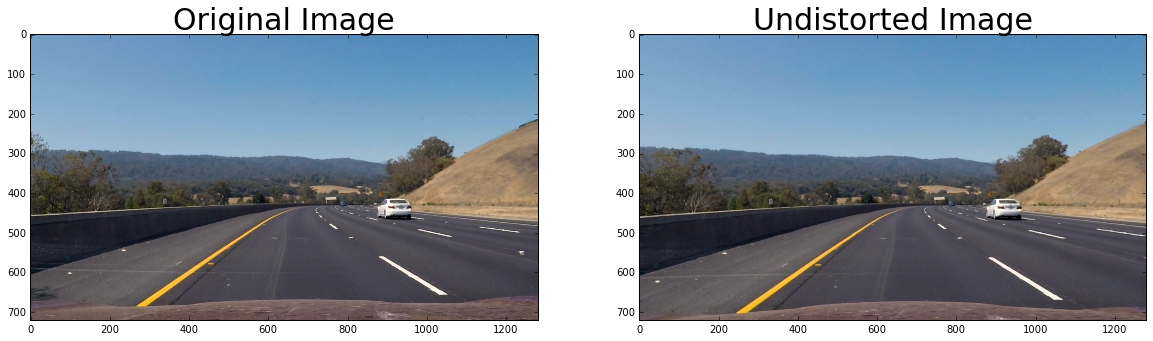

In [4]:
input_dir ="test_images/"
filename = "test3.jpg"
image = mpimg.imread(input_dir+filename)

dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

undis_image = undistort_image(image, mtx,dist)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undis_image)
ax2.set_title('Undistorted Image', fontsize=30)



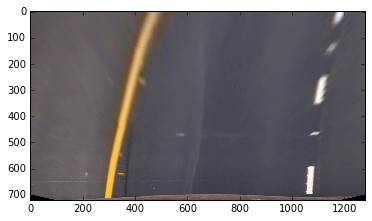

In [5]:
"""get Bird's-eye view"""

img_size = (undis_image.shape[1],undis_image.shape[0])

ltop = 0.07
lbottom = 0.44
x1, y1 = int(round(img_size[0]*(0.5-ltop))) , int(round(img_size[1]*(0.579166667 + ltop*0.847222222)))  
x2, y2 = int(round(img_size[0]*(0.5+ltop))) , y1
x3, y3 = img_size[0], img_size[1]
x4, y4 = 0, img_size[1]
        
src = np.float32([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])

M,Minv = getPerspectiveTransform_values(img_size, src,100 )

warped_image = warp_image(undis_image,M)
plt.imshow(warped_image)

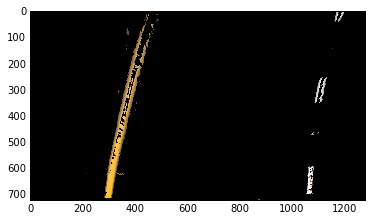

In [6]:
image_processed = colorMask_SobelFilter(warped_image)
#plt.imshow(image_processed)
nimage = cv2.bitwise_and(warped_image,warped_image, mask= image_processed)
plt.imshow(nimage)

##### a.	fit_polinomial_sliding_windows
Compute lines for the first frame or the last line found is very different to the previous lines (average):
###### 1.	Divide the image in 2 parts and perform a sum of the bottom part for axis “y” over axis “x” and get a histogram of the sum (axis X).
###### 2.	Get the maximum value for the left and right side, probably they are a good starting point for lane finding.
###### 3.	If there is a lot of values (200) greater than the middle of the max value, then reevaluate it only for the bottom window (1/9), probably it is a curve and we only need the starting point.
###### 4.	 Perform window sliding windows to know the area of interest, for the re-center next window on their mean position it also will affect the re-center for the new position in y:
win_y_left = int(win_y_left- (window_height-abs(leftx_current-old_leftx_current)))
###### 5.	Fit a second order polynomial function for each line

C:\Users\user\Downloads\WinPython-64bit-3.4.4.2\python-3.4.4.amd64\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 0)

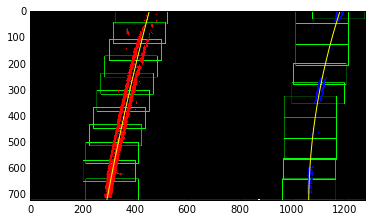

In [7]:

 # Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 200
 # Choose the number of sliding windows
nwindows = 9

def  fit_polinomial_sliding_windows (binary_warped, margin, minpix, nwindows ):
     # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2) 
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    #Separate histogram
    left_histogram =  histogram[:midpoint-margin*2]
    right_histogram =  histogram[midpoint+margin*2:]
    
    # Validate if the histogram has a good starting point
    leftx_count = len(histogram[histogram > (np.max(histogram[:midpoint-margin*2])/2)])
    rightx_count = len(histogram[histogram > (np.max(histogram[midpoint+margin*2:])/2)])
    if (leftx_count>200):
        #if there is a lot of noise in left side, use only dafa from the first window
        histogram = np.sum(binary_warped[binary_warped.shape[0]*(nwindows-1)/nwindows:,:], axis=0)
        left_histogram =  histogram[:midpoint-margin*2]
        
    if (rightx_count>200):
        #if there is a lot of noise in right side, use only dafa from the first window
        histogram = np.sum(binary_warped[binary_warped.shape[0]*(nwindows-1)/nwindows:,:], axis=0)
        right_histogram =  histogram[midpoint+margin*2:]
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    leftx_base = np.argmax(left_histogram)
    rightx_base = np.argmax(right_histogram) + midpoint+margin*2
    
     # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Starting point for Current positions to be updated for each window
    if leftx_base<margin:
        leftx_current = margin+1
    else:
        leftx_current = leftx_base
        
    if rightx_base > (binary_warped.shape[1] - margin):
        rightx_current = binary_warped.shape[1] - margin-1
    else:
        rightx_current = rightx_base
    
    #Area of interest for left side
    win_y_left = binary_warped.shape[0] - window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    # Create empty lists to receive left  lane pixel indices
    left_lane_inds = []
    # Step through the windows one by one
    lpixels=0
    while (win_xleft_low>-50)&(win_xleft_high<binary_warped.shape[1])&(win_y_left>-50):# Step through the windows one by one
        
        # Identify window boundaries in x and y
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        cv2.rectangle(out_img,(win_xleft_low,win_y_left),(win_xleft_high,win_y_left+window_height),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        lpixels=lpixels+window_height
        good_left_inds = ((nonzeroy >= win_y_left) & (nonzeroy < (win_y_left+window_height)) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            old_leftx_current =copy.copy(leftx_current)
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            #move in 'y' is inversely proportional to move in 'x'
            win_y_left = int(win_y_left- (window_height-abs(leftx_current-old_leftx_current)))
        else:
            win_y_left = win_y_left- window_height  

    
    #Area of interest for right side
    win_y_right = binary_warped.shape[0] - window_height
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Create empty lists to receive right lane pixel indices
    right_lane_inds = []
    rpixels=0
    while (win_xright_low>-50)&(win_xright_high<binary_warped.shape[1])&(win_y_right>-50):# Step through the windows one by one
        # Identify window boundaries in x and y 
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rpixels=rpixels+window_height####
        cv2.rectangle(out_img,(win_xright_low,win_y_right),(win_xright_high,win_y_right+window_height),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_right_inds = ((nonzeroy >= win_y_right) & (nonzeroy < (win_y_right+window_height)) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_right_inds) > minpix:        
            old_rightx_current =copy.copy(rightx_current)
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            #move in 'y' is inversely proportional to move in 'x'
            win_y_right = int(win_y_right - (window_height-abs(rightx_current-old_rightx_current)))
        else:
            win_y_right = win_y_right- window_height
    # Concatenate the arrays of indices

    if len(left_lane_inds)>0 and len(right_lane_inds)>0:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        left_count = len(lefty)//lpixels
        right_count = len(righty)//rpixels


        # Fit a second order polynomial to each
        if len(lefty)>0:
            left_fit = np.polyfit(lefty, leftx, 2)
        if len(righty)>0:
            right_fit = np.polyfit(righty, rightx, 2)

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        return copy.copy(Verify_line.best_left_fitx), copy.copy(Verify_line.best_right_fitx), out_img , 0,0
         

    
    return left_fitx, right_fitx, out_img , left_count, right_count

left_fitx, right_fitx, out_img , left_count, right_count= fit_polinomial_sliding_windows (image_processed, margin, minpix, nwindows)


ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )


    
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


##### b.	fit_polinomial_based_on_lines - Compute the lines based on previous lines:
###### 1.	Use the last polynomial found and add margin to know the area of interest.
###### 2.	Fit a second order polynomial function for each line
###### 3.	It is most faster, but if the changes are big regarding the last line found it will not be useful and we will go back to use fit_polinomial_sliding_windows

(720, 0)

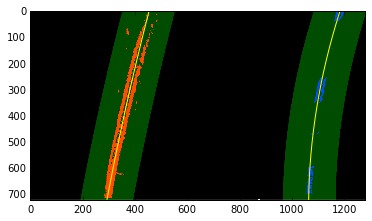

In [8]:
def fit_polinomial_based_on_lines (binary_warped, left_fit, right_fit, margin):  
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
 
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    

    # Fit a second order polynomial to each
    if len(lefty)>0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx)>0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    # Color in left and right line pixels
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_count = len(leftx)// len(ploty[(left_fitx>=0 )|  (left_fitx<out_img.shape[1]) ] ) 
    right_count = len(righty)//len(ploty[(right_fitx>=0 )|  (right_fitx<out_img.shape[1]) ] ) 
    
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(np.array(out_img,np.uint8), 1, np.array(window_img,np.uint8), 0.3, 0)
    
    

    return left_fitx, right_fitx, result, left_count, right_count

ploty = np.linspace(0, image_processed.shape[0]-1, image_processed.shape[0] )
left_fit = np.polyfit(ploty, left_fitx, 2)
right_fit = np.polyfit(ploty, right_fitx, 2)
    
left_fitx, right_fitx, nout_img , left_count, right_count= fit_polinomial_based_on_lines (image_processed, left_fit, right_fit,100)
#Create an image to draw on and an image to show the selection window
plt.imshow(nout_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


#### 5.	Lane finding
#### a.	With the previous techniques we found the second order polynomial function for each line, then we know the shape of the lane. 
#### b.	Draw the 2 lines
#### c.	Calculate the radius of curvature of each line with the respective scale, in this case y= 3/80 (3 meters for 80 pixels) and x= 3.7/740 (3.4 meters for 740 pixels). For the final curvature I performed an average over both radius  of curvature (left line and right line) 
#### d. Calculate the position of the vehicle with respect to center. It is a average of the bottom pixels (x value) of each  line found:
`int((left_fitx[-1]+right_fitx[-1])/2 - (img.shape[1]/2))`
The code for this step  is contained in the function `draw_lines` of the IPython notebook located in "./P4-CarND-Advanced-Lane-Lines-master.ipynb" 

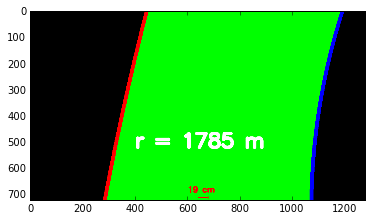

In [9]:
def draw_lines(img, left_fitx, right_fitx, margin , ym_per_pix,xm_per_pix ):
    # Create an image to draw on and an image to show the selection window
    window_img = np.zeros_like(np.array(img,np.uint8))
   
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
 
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([pts]), (0,255, 0))
    
    
    image_center_label = str( int(abs(((left_fitx[-1]+right_fitx[-1])/2 - (img.shape[1]/2))*xm_per_pix*100 )))+" cm"
    image_center_value = int((left_fitx[-1]+right_fitx[-1])/2 - (img.shape[1]/2))
    
    
    
    y_eval = np.max(ploty)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    average_curverad = "r = " + str(int((left_curverad + right_curverad)/2))+' m'
    # Now our radius of curvature is in meters
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    
    cv2.putText(window_img,average_curverad,(400,520), font, 2.5,(255,255,255),12,cv2.LINE_AA)
    
    if image_center_value<0:
        cv2.putText(window_img,image_center_label,(600,690), font, 1,(0,0,255),4,cv2.LINE_AA)
        cv2.line(window_img,(640,710),(640+image_center_value,710),(0,0,255),2)
        cv2.line(window_img,(640+image_center_value,705),(640+image_center_value,715),(0,0,255),2)
    else:
        cv2.putText(window_img,image_center_label,(600,690), font, 1,(255,0,0),4,cv2.LINE_AA)
        cv2.line(window_img,(640,710),(640+image_center_value,710),(255,0,0),2)
        cv2.line(window_img,(640+image_center_value,705),(640+image_center_value,715),(255,0,0),2)
    
    
    return window_img, left_curverad, right_curverad


n,left_curverad,right_curverad = draw_lines(warped_image, left_fitx, right_fitx, 15, 3/80, 3.7/740)
plt.imshow(n)
   

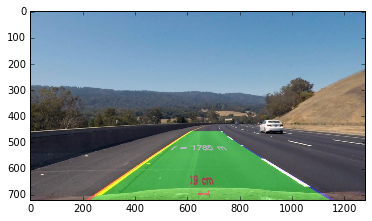

In [10]:
def get_road_unwarped(img, lines, Minv):
    img_size = (img.shape[1],img.shape[0])
    window_img = cv2.warpPerspective(lines,Minv,img_size)
    result = cv2.addWeighted(np.array(img,np.uint8), 1, np.array(window_img,np.uint8), 0.4, 0)
    return result

road_unwarped = get_road_unwarped(undis_image, n, Minv)

plt.imshow(road_unwarped)    


In [11]:
def process_image(img):
    img = undistort_image(img, mtx,dist)
      
    warped_image = warp_image(img,M)
    
    
    img_colorMask_SobelFilter = colorMask_SobelFilter(warped_image)
    nimg = cv2.bitwise_and(warped_image,warped_image, mask= img_colorMask_SobelFilter)
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 200
    # Choose the number of sliding windows
    nwindows = 9
    
    if Verify_line.left_fit == None:
        Verify_line.current_left_fitx, Verify_line.current_right_fitx, out_img , Verify_line.left_count, Verify_line.right_count = fit_polinomial_sliding_windows (img_colorMask_SobelFilter, margin, minpix, nwindows)
        Verify_line.get_best_fit()
    else:
        Verify_line.current_left_fitx, Verify_line.current_right_fitx, out_img, Verify_line.left_count, Verify_line.right_count = fit_polinomial_based_on_lines (img_colorMask_SobelFilter, Verify_line.left_fit, Verify_line.right_fit, 50)
        Verify_line.get_best_fit()
        if Verify_line.detected==False :
            Verify_line.current_left_fitx, Verify_line.current_right_fitx, out_img, Verify_line.left_count, Verify_line.right_count = fit_polinomial_sliding_windows (img_colorMask_SobelFilter, margin, minpix, nwindows)
            Verify_line.get_best_fit()
    
    
    road_warped,left_curverad,right_curverad = draw_lines(warped_image, Verify_line.best_left_fitx, Verify_line.best_right_fitx, 15, 3/100, 3.7/740)
    
    road_unwarped = get_road_unwarped(img,road_warped, Minv)

    g_scale = 0.25
    wimage_overlay = cv2.resize(warped_image, (0,0), fx=g_scale, fy=g_scale) 
    nimage_overlay  = cv2.resize(nimg, (0,0), fx=g_scale, fy=g_scale) 
    rimage_overlay  = cv2.resize(out_img, (0,0), fx=g_scale, fy=g_scale)  
    roimage_overlay = cv2.resize(road_warped, (0,0), fx=g_scale, fy=g_scale) 


    Minimage_size = (wimage_overlay.shape[0], wimage_overlay.shape[1])

    road_unwarped[0:Minimage_size[0], 0:Minimage_size[1]] = wimage_overlay
    road_unwarped[0:Minimage_size[0], Minimage_size[1]:2*Minimage_size[1]] = nimage_overlay
    road_unwarped[0:Minimage_size[0], 2*Minimage_size[1]:3*Minimage_size[1]] = rimage_overlay
    road_unwarped[0:Minimage_size[0], 3*Minimage_size[1]:4*Minimage_size[1]] = roimage_overlay
    
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(road_unwarped,"radius of curvature for left line: " + str(int(left_curverad))+" m",(30,200), font, 0.7,(255,255,0),2,cv2.LINE_AA)
    cv2.putText(road_unwarped,"radius of curvature for right line: " + str(int(right_curverad))+" m",(30,230), font, 0.7,(255,255,0),2,cv2.LINE_AA)
    cv2.putText(road_unwarped,"radius of curvature (r): " + str(int((left_curverad + right_curverad)/2))+" m",(30,260), font, 0.7,(255,255,0),2,cv2.LINE_AA)


    return road_unwarped

    

In [15]:
input_dir="test_images/"
dirs = os.listdir(input_dir)
images = []
undis_images = []
files =[]
dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

for file in dirs:
    if (file.find("test")==0):
        print (input_dir+file)
        Verify_line = Lines(1) ##Clean previous lines
        Verify_line.set_ploty(720) 
        
        image = cv2.imread(input_dir+file)
        nimage = process_image(image)
        cv2.imwrite('output_images/'+file,nimage)
        

test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg
test_images/test6.jpg


In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
challenge_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
Verify_line = Lines(10)
Verify_line.set_ploty(720) 
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [06:26<00:00,  1.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 6min 29s


In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
challenge_output = 'project_video_output.mp4'
clip2 = VideoFileClip('project_video.mp4')
Verify_line = Lines(5)
Verify_line.set_ploty(720) 
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [16:21<00:00,  1.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 16min 25s
